In [3]:
import os
import glob
import time
import datetime
import pandas as pd
import numpy as np
import io
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.amp import GradScaler, autocast

# Set the device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import precision_recall_curve, auc, f1_score, confusion_matrix, ConfusionMatrixDisplay
from generate_anomaly_score import generate_anomaly_score
import random
np.random.seed(42)
random.seed(42)

In [29]:
# load training data
df_all = pd.read_csv('shf_all_2324.csv', index_col = 'timestamp')
df_all

# load test data
root_dir = './test_TL'
model_files = ['lstm_small.pth']  # Add more model files as needed
data_files = ['inter_leakage.csv', 'pump_failure.csv']

<Axes: xlabel='time_window_start'>

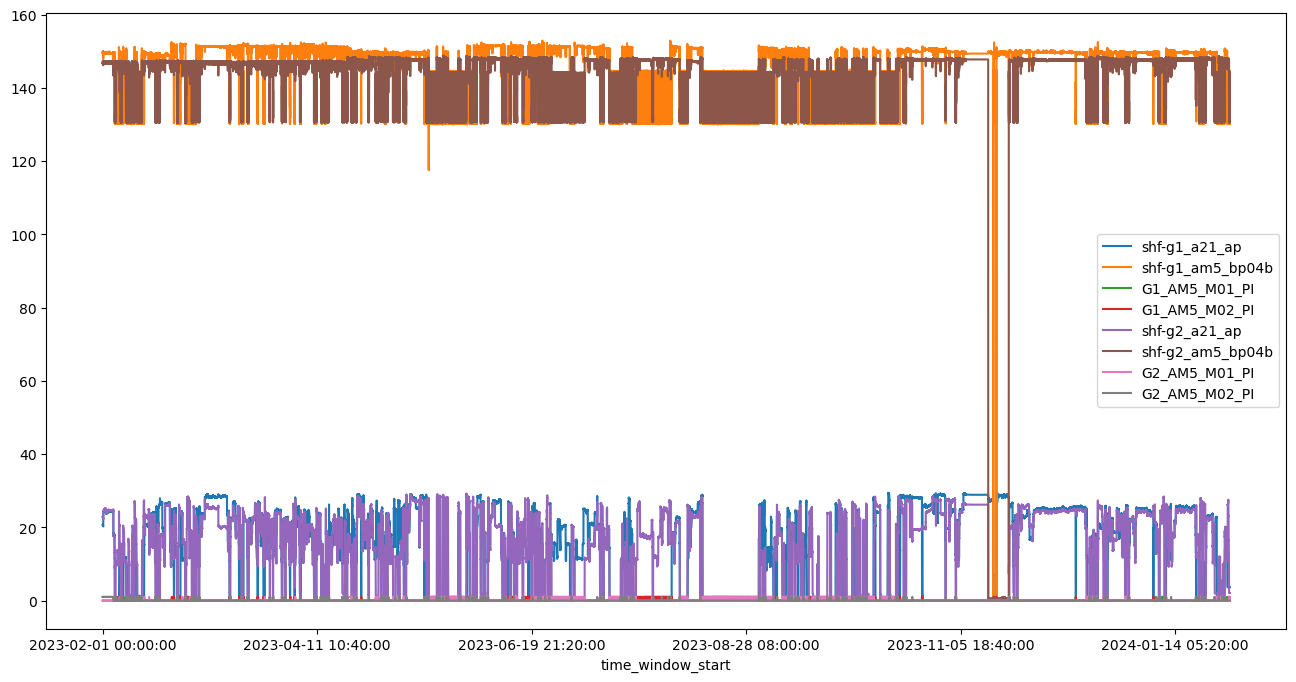

In [4]:
df_all.plot(figsize=(16,8))

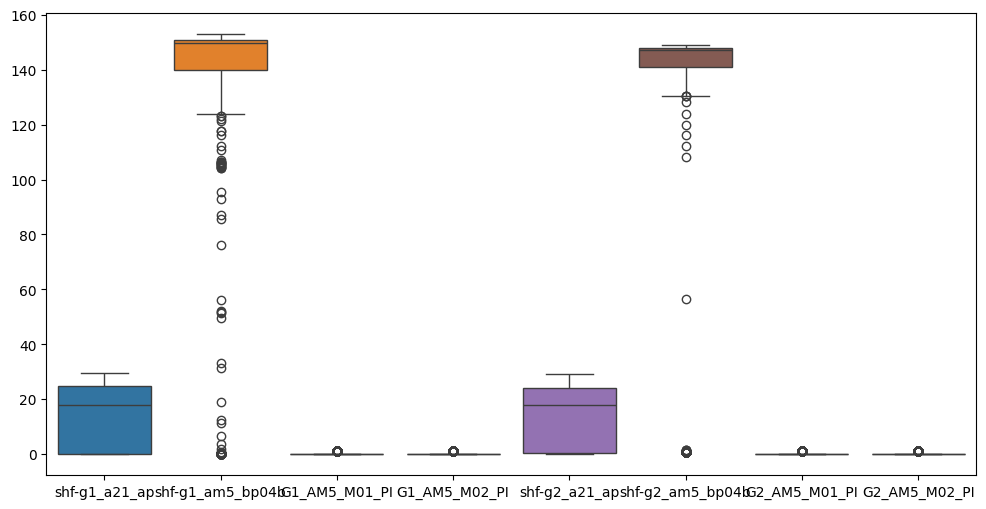

In [5]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_all)
plt.show()

In [30]:
#standardization
scaler = StandardScaler()
combined_data = np.vstack([df_all.iloc[:,[4,5]], df_all.iloc[:,[0,1]]])
scaler.fit_transform(combined_data)
df_all.iloc[:,[4,5]] = scaler.transform(df_all.iloc[:,[4,5]])
df_all.iloc[:,[0,1]] = scaler.transform(df_all.iloc[:,[0,1]])
df_all

c:\Users\zongxia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\zongxia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


,active_power_u1,oil_pressure_u1,oil_pump1_u1,oil_pump2_u1,active_power_u2,oil_pressure_u2,oil_pump1_u2,oil_pump2_u2
timestamp,,,,,,,,
2023-02-01 00:00:00,0.571640,0.389636,1.0,0.0,0.777750,0.192034,0.0,1.0
2023-02-01 00:01:00,0.571640,0.373169,1.0,0.0,0.782435,0.192034,0.0,1.0
2023-02-01 00:02:00,0.571640,0.372996,1.0,0.0,0.777750,0.192504,0.0,1.0
2023-02-01 00:03:00,0.571640,0.373640,1.0,0.0,0.777750,0.190936,0.0,1.0
2023-02-01 00:04:00,0.571640,0.377195,1.0,0.0,0.782435,0.192400,0.0,1.0
...,...,...,...,...,...,...,...,...
2024-01-31 23:56:00,-1.023584,-0.237268,0.0,0.0,-1.174510,-0.349226,0.0,0.0
2024-01-31 23:57:00,-1.023584,-0.264099,0.0,0.0,-1.174510,-0.463348,0.0,0.0
2024-01-31 23:58:00,-1.023584,-0.281706,0.0,0.0,-1.174510,-0.555563,0.0,0.0


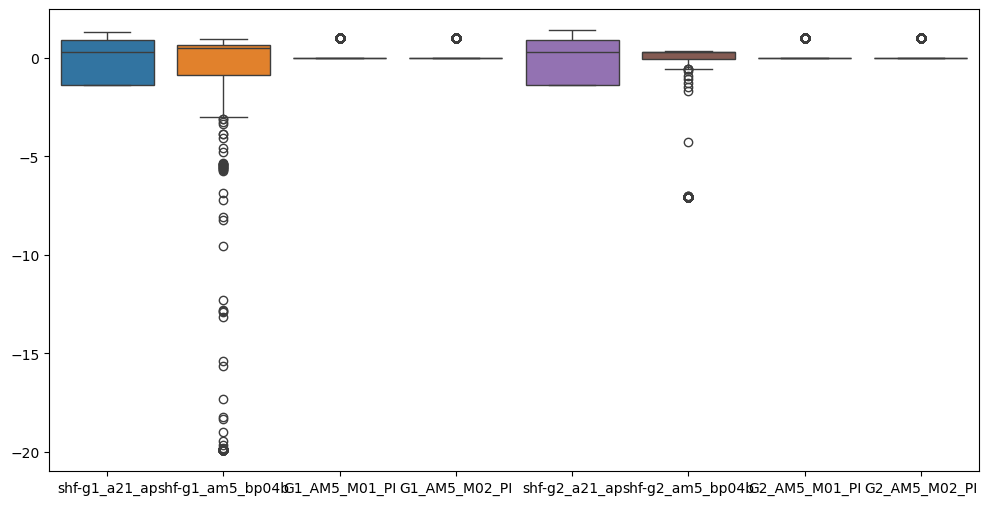

In [7]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_all)
plt.show()

In [9]:
X_source = df_all.iloc[:,:4].loc['2023-08-14 08:00:00':'2023-09-01 08:00:00']
X_target_full = df_all.iloc[:,4:].loc['2023-07-03 14:00:00':'2023-07-07 00:00:00']
X_target_small = df_all.iloc[:,4:].loc['2023-06-30 00:00:00':'2023-07-01 00:00:00']
X_source.shape, X_target_full.shape, X_target_small.shape

((25921, 4), (4921, 4), (1441, 4))

In [34]:
X_source = df_all.iloc[:,:4].loc['2023-02-01 00:00:00 ':'2024-02-01 00:00:00']
X_target_full = df_all.iloc[:,4:].loc['2023-02-01 00:00:00 ':'2024-01-01 00:00:00']
X_target_small = df_all.iloc[:,4:].loc['2024-01-01 00:00:00':'2024-02-01 00:00:00']
X_source.shape, X_target_full.shape, X_target_small.shape

((525600, 4), (480960, 4), (44641, 4))

In [35]:
#resample data for smaller datasets
def resample_data(df, new_frequency='5min'):
    # Ensure that the index is a DateTimeIndex
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
    
    # Resample the data to the specified frequency, using the mean as the aggregation method
    resampled_df = df.resample(new_frequency).mean()
    
    return resampled_df


X_source = resample_data(X_source)
X_target_full = resample_data(X_target_full)
X_target_small = resample_data(X_target_small)
X_source.shape, X_target_full.shape, X_target_small.shape

((105121, 4), (96193, 4), (8929, 4))

In [36]:
def prepare_data(X, sequence_length):
    # Convert the input dataframe to a tensor
    X_tensor = torch.tensor(X.to_numpy(), dtype=torch.float32)
    
    # Calculate the number of sequences that can be created
    num_samples = X_tensor.shape[0] - sequence_length + 1
    num_features = X_tensor.shape[1]
    
    # Create a view with sliding windows of size (sequence_length, num_features)
    X_sequences = torch.zeros((num_samples, sequence_length, num_features), dtype=torch.float32)
    
    for i in range(num_samples):
        X_sequences[i] = X_tensor[i:i + sequence_length]
    
    # Create a dataset
    dataset = TensorDataset(X_sequences)
    print(X_sequences.shape)
    return dataset


# Hyperparameters
input_dim = 4  # Since each sample has 4 features
hidden_dim = 128  # Increased hidden dimension for LSTM
num_layers = 2  # LSTM layers
sequence_length = 60  # Sequence length for LSTM (each data point is treated as one time step)
dropout = 0.2  # Dropout rate to prevent overfitting

# Prepare datasets
source_dataset = prepare_data(X_source, sequence_length)
target_full_dataset = prepare_data(X_target_full, sequence_length)
target_small_dataset = prepare_data(X_target_small, sequence_length)

torch.Size([105062, 60, 4])
torch.Size([96134, 60, 4])
torch.Size([8870, 60, 4])


In [37]:
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout):
        super(LSTMAutoencoder, self).__init__()
        
        # Encoder
        self.encoder_lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.encoder_fc = nn.Linear(hidden_dim, hidden_dim)
        self.layer_norm = nn.LayerNorm(hidden_dim)  # Layer Normalization
        
        # Decoder
        self.decoder_fc = nn.Linear(hidden_dim, hidden_dim)
        self.decoder_lstm = nn.LSTM(hidden_dim, input_dim, num_layers, batch_first=True, dropout=dropout)

    def forward(self, x):
        # Encoder
        _, (h, _) = self.encoder_lstm(x)
        encoded = self.encoder_fc(h[-1])
        encoded = self.layer_norm(encoded)  # Add normalization

        # Decoder
        decoded = self.decoder_fc(encoded).unsqueeze(1).repeat(1, x.size(1), 1)
        decoded, _ = self.decoder_lstm(decoded)
        
        return decoded


# Pretrain function
scaler = GradScaler()

def pretrain(model, data, epochs=50, batch_size=64, learning_rate=1e-3):  # Decreased learning rate for more stable training
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-6)  # Reduced weight decay for less regularization
    criterion = nn.SmoothL1Loss()  # Changed to Huber Loss for more robustness to outliers
    
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=False, num_workers=4)
    best_loss = float('inf')
    patience = 10  # Increased patience to allow more epochs before early stopping
    counter = 0
    
    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            batch = batch[0].to(device)
            
            with autocast('cuda'):
                optimizer.zero_grad()
                output = model(batch)
                loss = criterion(output, batch)

            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping to prevent exploding gradients
            scaler.step(optimizer)
            scaler.update()
            
            total_loss += loss.item()
        
        epoch_loss = total_loss / len(dataloader)
        print(f"Pretrain Epoch {epoch+1}/{epochs}, Loss: {epoch_loss}")
    
        # Early Stopping Check
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping")
                break


# Fine-tune function
def finetune(model, data, epochs=20, batch_size=64, learning_rate=1e-3, train_last_layer_only=True):  # Decreased learning rate for fine-tuning
    if train_last_layer_only:
        for name, param in model.named_parameters():
            if 'encoder_lstm' in name:
                param.requires_grad = False

    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-6)  # Reduced weight decay for less regularization
    criterion = nn.SmoothL1Loss()  # Changed to Huber Loss for more robustness to outliers
    
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=False, num_workers=4)
    
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            batch = batch[0].to(device)  # Extract the tensor from the tuple/list and move to device
            optimizer.zero_grad()
            output = model(batch)
            loss = criterion(output, batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping to prevent exploding gradients
            optimizer.step()
            total_loss += loss.item()
        
        print(f"Finetune Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloader)}")


c:\Users\zongxia\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\amp\grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [16]:
# -------------------- Training with Transfer Learning: X_source -> X_target_small--------------------
torch.cuda.empty_cache()

# Initialize LSTM Autoencoder
lstm_autoencoder_1 = LSTMAutoencoder(input_dim, hidden_dim, num_layers, dropout).to(device)

# Pretrain on X_source
pretrain(lstm_autoencoder_1, source_dataset, epochs=50)

# Fine-tune on X_target_small
finetune(lstm_autoencoder_1, target_small_dataset, epochs=20, train_last_layer_only=True)

# Save model
torch.save(lstm_autoencoder_1.state_dict(), "lstm_autoencoder_TL_u1.pth")
print('model saved')

Pretrain Epoch 1/50, Loss: 0.19487038822656033
Pretrain Epoch 2/50, Loss: 0.2204472543354811
Pretrain Epoch 3/50, Loss: 0.2231443593594451
Pretrain Epoch 4/50, Loss: 0.22328323697128638
Pretrain Epoch 5/50, Loss: 0.2196579004364087
Pretrain Epoch 6/50, Loss: 0.21884476225048952
Pretrain Epoch 7/50, Loss: 0.21768788962078198
Pretrain Epoch 8/50, Loss: 0.21708839963928736
Pretrain Epoch 9/50, Loss: 0.21692791032860392
Pretrain Epoch 10/50, Loss: 0.21692960803486616
Pretrain Epoch 11/50, Loss: 0.21689599579136057
Early stopping
Finetune Epoch 1/20, Loss: 0.08550681657574086
Finetune Epoch 2/20, Loss: 0.08257988595618136
Finetune Epoch 3/20, Loss: 0.0792358238987035
Finetune Epoch 4/20, Loss: 0.07813577366014607
Finetune Epoch 5/20, Loss: 0.0776607450081049
Finetune Epoch 6/20, Loss: 0.07745558335177814
Finetune Epoch 7/20, Loss: 0.07732707907767336
Finetune Epoch 8/20, Loss: 0.07723842388883287
Finetune Epoch 9/20, Loss: 0.07716475802694829
Finetune Epoch 10/20, Loss: 0.07710539447411681


In [17]:
# -------------------- Training on Full Target Data: X_target_full -> X_target_small --------------------
# Initialize LSTM Autoencoder
lstm_autoencoder_2 = LSTMAutoencoder(input_dim, hidden_dim, num_layers, dropout).to(device)

# Pretrain on X_target_full
pretrain(lstm_autoencoder_2, target_full_dataset, epochs=50)

# Fine-tune on X_target_small
finetune(lstm_autoencoder_2, target_small_dataset, epochs=20, train_last_layer_only=True)

# Save model
torch.save(lstm_autoencoder_2.state_dict(), "lstm_autoencoder_TL_u2.pth")
print('model saved')

Pretrain Epoch 1/50, Loss: 0.15463735773249795
Pretrain Epoch 2/50, Loss: 0.16746275784676748
Pretrain Epoch 3/50, Loss: 0.168612716331186
Pretrain Epoch 4/50, Loss: 0.16733437658415232
Pretrain Epoch 5/50, Loss: 0.16700844029361983
Pretrain Epoch 6/50, Loss: 0.16706377280931345
Pretrain Epoch 7/50, Loss: 0.16644479290553427
Pretrain Epoch 8/50, Loss: 0.16609988815794963
Pretrain Epoch 9/50, Loss: 0.1662606538164337
Pretrain Epoch 10/50, Loss: 0.16681344278314147
Pretrain Epoch 11/50, Loss: 0.16624749647922807
Early stopping
Finetune Epoch 1/20, Loss: 0.091769978028836
Finetune Epoch 2/20, Loss: 0.08255021107590778
Finetune Epoch 3/20, Loss: 0.0782269902473731
Finetune Epoch 4/20, Loss: 0.07779416695853575
Finetune Epoch 5/20, Loss: 0.07761489798770481
Finetune Epoch 6/20, Loss: 0.0774690709127073
Finetune Epoch 7/20, Loss: 0.07736710134538548
Finetune Epoch 8/20, Loss: 0.07728444426923507
Finetune Epoch 9/20, Loss: 0.07720920264640514
Finetune Epoch 10/20, Loss: 0.07714637591362856
Fi

In [18]:
# -------------------- Training without Transfer Learning: X_target_small only--------------------

# Initialize LSTM Autoencoder
lstm_autoencoder_3 = LSTMAutoencoder(input_dim, hidden_dim, num_layers, dropout).to(device)

# Train directly on X_target_small without pretraining
pretrain(lstm_autoencoder_3, target_small_dataset, epochs=80)

# Save model
torch.save(lstm_autoencoder_3.state_dict(), "lstm_autoencoder_small.pth")
print('model saved')

Pretrain Epoch 1/80, Loss: 0.09488921037292201
Pretrain Epoch 2/80, Loss: 0.08487799683612564
Pretrain Epoch 3/80, Loss: 0.07910538598620366
Pretrain Epoch 4/80, Loss: 0.07963330918427208
Pretrain Epoch 5/80, Loss: 0.08154518159421281
Pretrain Epoch 6/80, Loss: 0.08283331616372942
Pretrain Epoch 7/80, Loss: 0.08070964854053161
Pretrain Epoch 8/80, Loss: 0.07907817556469185
Pretrain Epoch 9/80, Loss: 0.07823346106489625
Pretrain Epoch 10/80, Loss: 0.07772544430227106
Pretrain Epoch 11/80, Loss: 0.0774079778050776
Pretrain Epoch 12/80, Loss: 0.07720796145136943
Pretrain Epoch 13/80, Loss: 0.07707901801176958
Pretrain Epoch 14/80, Loss: 0.07699760668341527
Pretrain Epoch 15/80, Loss: 0.07616780990761497
Pretrain Epoch 16/80, Loss: 0.07607713630992463
Pretrain Epoch 17/80, Loss: 0.07648615862356781
Pretrain Epoch 18/80, Loss: 0.07692631339426521
Pretrain Epoch 19/80, Loss: 0.07735428370521974
Pretrain Epoch 20/80, Loss: 0.07773684042593022
Pretrain Epoch 21/80, Loss: 0.07806424563415616
Pr

In [ ]:
# Run the anomaly detection and save results
process_and_save_anomaly_scores(data_files, model_files, root_dir, scaler)